# Load the data 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

BASE_DIR = 'C:\\Users\\Rafael\\Desktop\\EDAN\\P\\lab3\\lab3_eda\\'
#BASE_DIR = 'C:\\Users\\Rafael\\Desktop\\EDAN\\p\\lab3\\lab3_eda\\'

df_microled = pd.read_csv(BASE_DIR + 'id-v-microled.csv')
df_cadence = pd.read_csv(BASE_DIR + 'micro_led_tb_cadence.csv')
df_cadence_limited = pd.read_csv(BASE_DIR + 'micro_led_tb_cadence_limited_exponential.csv')

df_microled_working_region = df_microled[(df_microled['/I2/p1 Y'] > 10e-9) & (df_microled['/I2/p1 Y'] < 3e-6)]

# Problem 1 (MicroLED)

# Curve fit for obtain current parameters

In [57]:
ut_microled = 0.026

def obtainId_microled(v,Is, vt, n):
    return Is * (np.exp((v-vt)/(n*ut_microled)) - 1)

[Is_microled,vt_microled,n_microled], pcov = curve_fit(obtainId_microled, df_microled_working_region['/I2/p1 X'], df_microled_working_region['/I2/p1 Y'], p0=(1e-3,1,1))

print('Is_microled = ', Is_microled)
print('vt_microled = ', vt_microled)
print('n_microled = ', n_microled)

Is_microled =  1.8590268202397832e-18
vt_microled =  1.2200800720116642
n_microled =  1.3239995374285203


# Plot Cadence current characteristic Vs experimental results

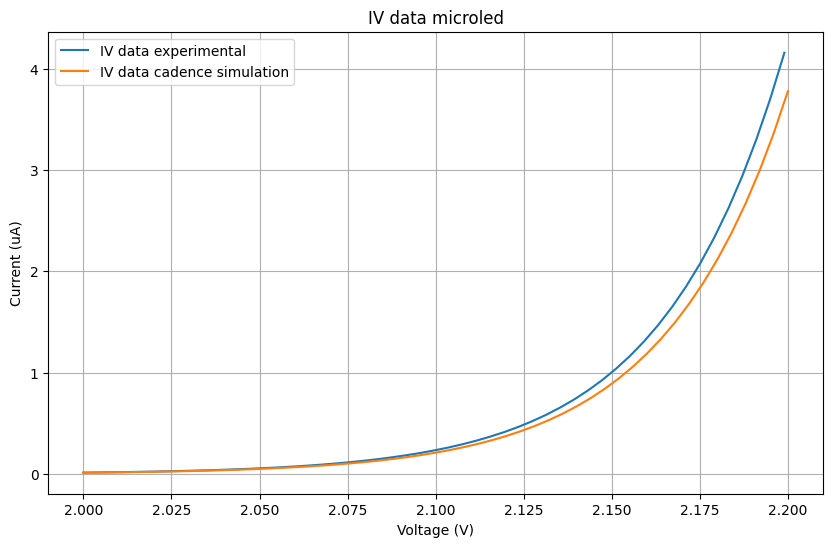

In [58]:
plt.figure(1, figsize=(10, 6))
plt.plot(df_microled['/I2/p1 X'], df_microled['/I2/p1 Y'] * 1e6, label='IV data experimental')
plt.plot(df_cadence['/I0/i X'], df_cadence['/I0/i Y'] * 1e6, label='IV data cadence simulation')   
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('IV data microled')
plt.grid()
plt.show()

Experimental Error

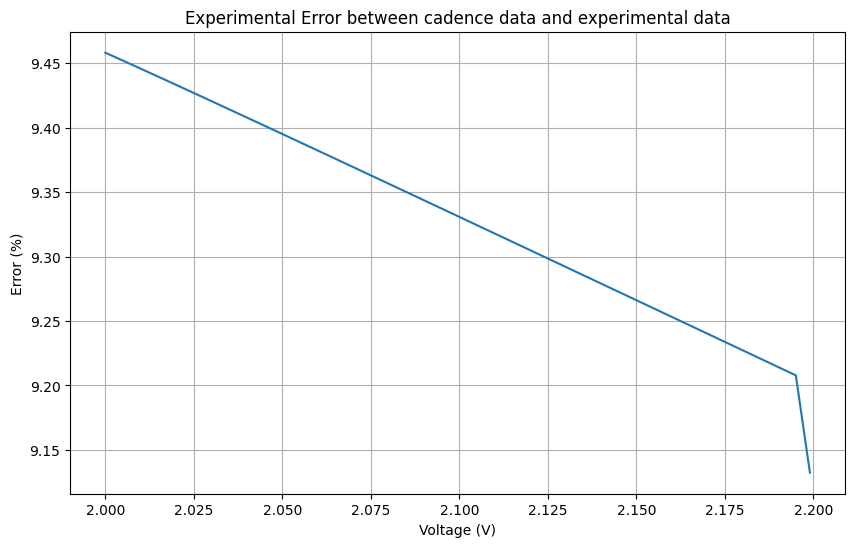

In [ ]:
plt.figure(2, figsize=(10, 6))
plt.plot(df_microled['/I2/p1 X'], (abs(df_cadence['/I0/i Y'] * 1e6 - df_microled['/I2/p1 Y'] * 1e6) / (df_microled['/I2/p1 Y'] * 1e6)) * 100)
plt.xlabel('Voltage (V)')
plt.ylabel('Error (%)')
plt.title('Experimental Error between cadence data and experimental data')
plt.grid()
plt.show()

# Limited Exponential (obtain linear function)

In [60]:
#get me the values of voltage and current for the current range between 2uA and 3 uA
df_microled_working_region_slope = df_microled_working_region[(df_microled_working_region['/I2/p1 Y'] > 2e-6) & (df_microled_working_region['/I2/p1 Y'] < 3e-6)]

print(df_microled_working_region_slope)
#obtain the linear function for these values 
slope_microled, intercept_microled = np.polyfit(df_microled_working_region_slope['/I2/p1 X'], df_microled_working_region_slope['/I2/p1 Y'], 1)

print('slope = ', slope_microled)
print('intercept = ', intercept_microled)


    /I2/p1 X  /I2/p1 Y
44   2.17512  0.000002
45   2.17910  0.000002
46   2.18308  0.000003
47   2.18706  0.000003
slope =  7.220179524735389e-05
intercept =  -0.0001549837382267023


# Current Function

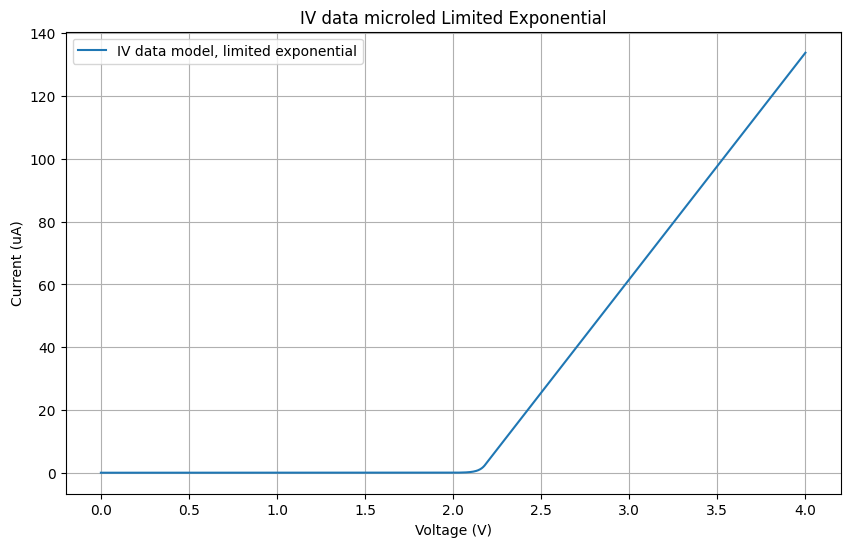

In [66]:
v_threshold_microled = 2.18706

def obtainId_microled_limited_exponential (v,Is, vt, n):
    return np.piecewise(v, [v < v_threshold_microled, v >= v_threshold_microled], [lambda v: Is * (np.exp((v-vt)/(n*ut_microled)) - 1), lambda v: slope_microled*v + intercept_microled])

v_microled = np.linspace(0, 4, 1000)

#plot the data for vgs between 0 and 4V
plt.figure(3, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('IV data microled Limited Exponential')
plt.grid()
plt.show()

# Validation Limited Exponential Cadence

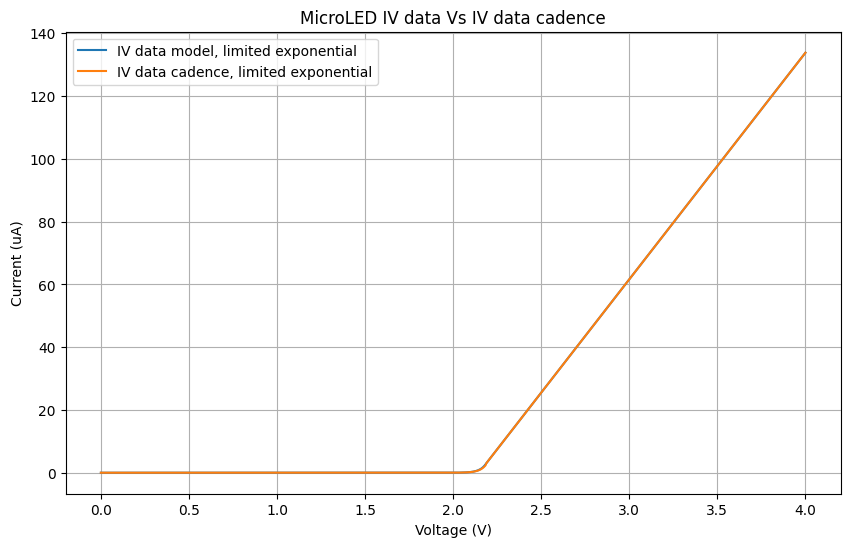

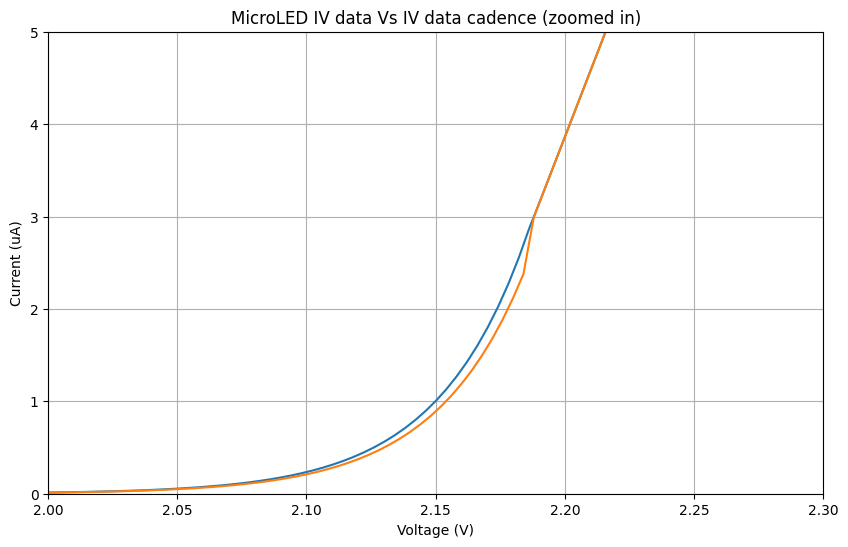

In [67]:
plt.figure(4, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.plot(df_cadence_limited['/I0/i X'], df_cadence_limited['/I0/i Y'] * 1e6, label='IV data cadence, limited exponential')   
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('MicroLED IV data Vs IV data cadence')
plt.grid()
plt.show() 

plt.figure(5, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.plot(df_cadence_limited['/I0/i X'], df_cadence_limited['/I0/i Y'] * 1e6, label='IV data cadence, limited exponential')   
plt.xlim(2,2.3)
plt.ylim(0,5)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.title('MicroLED IV data Vs IV data cadence (zoomed in)')
plt.grid()
plt.show()

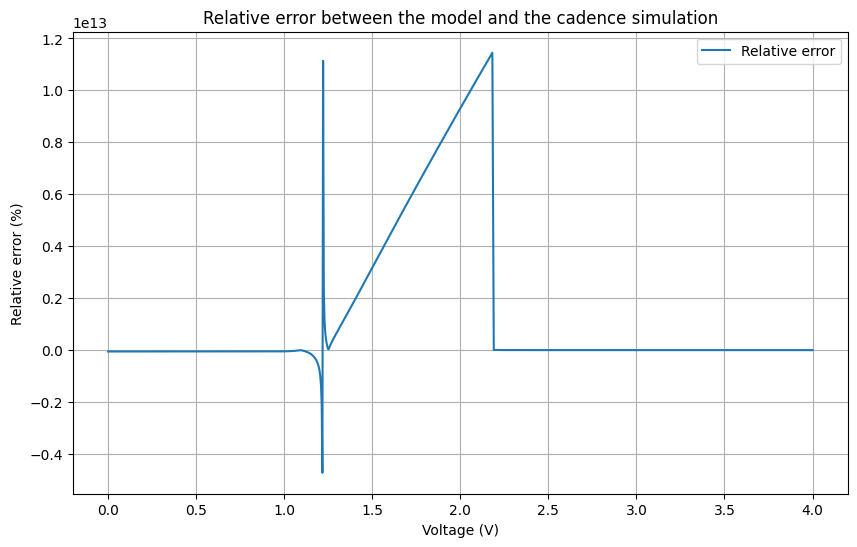

In [68]:
from scipy.interpolate import interp1d

# Interpolate the cadence data to match the shape of v_microled
interp_cadence = interp1d(df_cadence_limited['/I0/i X'], df_cadence_limited['/I0/i Y'] * 1e6, kind='linear', fill_value="extrapolate")
cadence_interpolated = interp_cadence(v_microled)

# Calculate the relative error
relative_error = (abs(cadence_interpolated - obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6) / obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6) * 100

plt.figure(5, figsize=(10, 6))
plt.plot(v_microled, relative_error, label='Relative error')
plt.xlabel('Voltage (V)')
plt.ylabel('Relative error (%)')
plt.legend(loc='best')
plt.title('Relative error between the model and the cadence simulation')
plt.grid()
plt.show()



# Problem 2

# TFT current

C:\Users\André Martins\AppData\Local\Temp\ipykernel_19368\2142520081.py:5: RuntimeWarning: invalid value encountered in power
  return np.where(vgs<vt, 0, bx*(woverl)*(vgs - vt)**m * (1 + obtainLambda_tft(vgs, a_3, b_3, c_3, d_3, e_3)*vds)) #need to check this


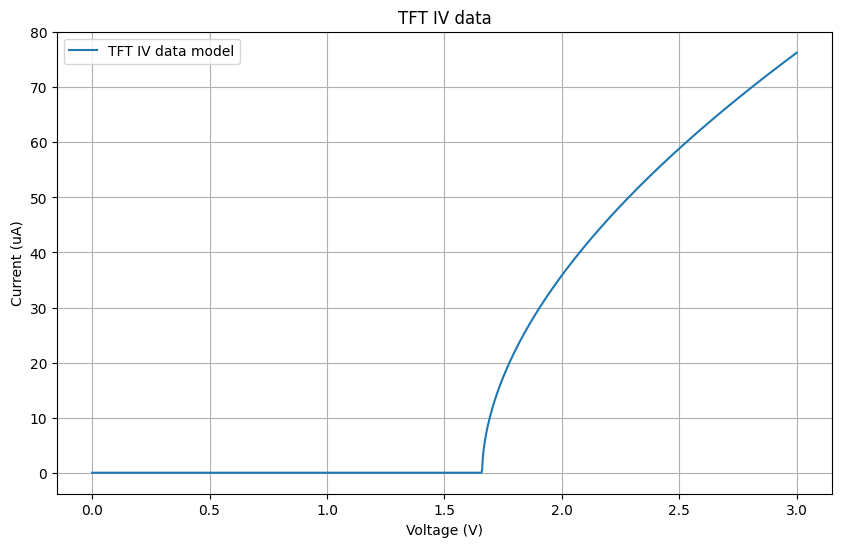

In [69]:
def obtainLambda_tft(vgs, a1, a2, a3, a4, a5):
     return a1*vgs**4 + a2*vgs**3 + a3*vgs**2 + a4*vgs + a5

def obtainId_tft (vgs, vds, vt, bx, woverl, m, a_3, b_3, c_3, d_3, e_3):
    return np.where(vgs<vt, 0, bx*(woverl)*(vgs - vt)**m * (1 + obtainLambda_tft(vgs, a_3, b_3, c_3, d_3, e_3)*vds)) #need to check this 

vgs_tft = np.linspace(0, 3, 1000)
vt_opt_tft = 1.6605193074083453
k_opt_tft = 6.342264896706637e-05
m_opt_tft = 0.5436425322516196

alpha_opt_tft = 0.9720095859570423
a1_opt_tft = 0.0004246212659893926
a2_opt_tft = -0.0038580151080255132
a3_opt_tft = 0.013797120680445802
a4_opt_tft = -0.01543728006841336
a5_opt_tft = 0.013585461081624358

b_x_tft = k_opt_tft/10
w_over_l_tft=k_opt_tft/b_x_tft

plt.figure(5, figsize=(10, 6))
plt.plot(vgs_tft, obtainId_tft(vgs_tft, 1.2, vt_opt_tft, b_x_tft, w_over_l_tft, m_opt_tft, a1_opt_tft, a2_opt_tft, a3_opt_tft, a4_opt_tft, a5_opt_tft) * 1e6, label='TFT IV data model')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('TFT IV data')
plt.grid()
plt.show()

# plt.figure(6, figsize=(10, 6))
# plt.plot(vgs_tft, obtainId_tft(vgs_tft, 1.2, vt_opt_tft, b_x_tft, w_over_l_tft, m_opt_tft, a1_opt_tft, a2_opt_tft, a3_opt_tft, a4_opt_tft, a5_opt_tft) * 1e6, label='TFT IV data model')
# plt.xlim(1.5,1.7)
# plt.ylim(0,5)
# plt.grid()
# plt.show()




# TFT Design

In [70]:
vd_tft = 3
vin_tft = 3
id_tft_microled = []

v_possible_values = np.linspace(vt_microled, vin_tft - vt_opt_tft, 100)

def obtain_woverl_tft(woverl_tft, v):
    return b_x_tft * woverl_tft * (vin_tft - v - vt_opt_tft)**m_opt_tft * (1 + obtainLambda_tft(vin_tft - v, a1_opt_tft, a2_opt_tft, a3_opt_tft, a4_opt_tft, a5_opt_tft)*(vd_tft-v)) - obtainId_microled_limited_exponential(v, Is_microled, vt_microled, n_microled)

for i in range(0,len(v_possible_values)):
    woverl_tft = fsolve(obtain_woverl_tft(v_possible_values[i]), 0, xtol= 1e-10)
    current_tft_microled = obtainId_tft(vin_tft - v_possible_values[i], vd_tft - v_possible_values[i], vt_opt_tft, b_x_tft, woverl_tft, m_opt_tft, a1_opt_tft, a2_opt_tft, a3_opt_tft, a4_opt_tft, a5_opt_tft)
    id_tft_microled.append(current_tft_microled)

print(id_tft_microled)

plt.figure(7, figsize=(10, 6))
plt.plot(woverl_tft, current_tft_microled * 1e6, label='Current Vs TFT W/L')
plt.xlabel('W/L')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('Current Vs TFT W/L')
plt.grid()
plt.show()


TypeError: obtain_woverl_tft() missing 1 required positional argument: 'v'